# Building a Malicious URL Detector

Task:

We are given a dataset of variuos `url`s, with columns `url` and `type` where type being the binary target column. We have to develop a machine learning model that can differentiate if a given `url` is `benign` or `defacement`.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Data Preprocessing and Feature Engineering

In [2]:
# Load the dataset as pandas dataframe
dataset_path = "/content/benign_vs_defacement_urls.csv"
df = pd.read_csv(dataset_path, encoding = "ISO-8859-1", on_bad_lines='warn')
df.head()

/tmp/ipython-input-1223258048.py:3: ParserWarning: Skipping line 463992: expected 2 fields, saw 3
Skipping line 502270: expected 2 fields, saw 3
Skipping line 517723: expected 2 fields, saw 3

  df = pd.read_csv(dataset_path, encoding = "ISO-8859-1", on_bad_lines='warn')


,url,type
0,mp3raid.com/music/krizz_kaliko.html,benign
1,bopsecrets.org/rexroth/cr/1.htm,benign
2,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
3,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
4,yourbittorrent.com/?q=anthony-hamilton-soulife,benign


In [3]:
# Malicious keywords
keywords = ['win', 'gold', 'bet', 'lottery', 'rummy', 'play', 'game', 'gov', 'money', 'crypto', 'trade']

for keyword in keywords:
    df[keyword] = df['url'].str.count(keyword)

# Check for shortened URL
shortened_url_expression = "(bit\.ly|tinyurl\.com|t\.co|rebrand\.ly|goo\.gl|ow\.ly|is\.gd|buff\.ly|adf\.ly|bit\.do|mcaf\.ee|su\.pr|v\.gd|tiny\.cc|shorte\.st|linksynergy\.com)"
df['is_shortened'] = df['url'].str.contains(shortened_url_expression)

<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-213531526.py:8: SyntaxWarning: invalid escape sequence '\.'
  shortened_url_expression = "(bit\.ly|tinyurl\.com|t\.co|rebrand\.ly|goo\.gl|ow\.ly|is\.gd|buff\.ly|adf\.ly|bit\.do|mcaf\.ee|su\.pr|v\.gd|tiny\.cc|shorte\.st|linksynergy\.com)"
/tmp/ipython-input-213531526.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_shortened'] = df['url'].str.contains(shortened_url_expression)


In [4]:
# Extracting other information
df['domain_extension'] = df['url'].str.extract('\.([a-z]{2,}(?:\.[a-z]{2,})?)(?:[/?#]|$)')
df['end_file_extension'] = df['url'].str.extract('\.([a-z]{2,})$')
df['digit_count'] = df['url'].str.count('[0-9]')
df['symbol_count'] = df['url'].str.count('[^0-9a-zA-z]')
df['alphabet_count'] = df['url'].str.count('[a-zA-z]')
df['http_count'] = df['url'].str.count('http')

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-989073814.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['domain_extension'] = df['url'].str.extract('\.([a-z]{2,}(?:\.[a-z]{2,})?)(?:[/?#]|$)')
/tmp/ipython-input-989073814.py:3: SyntaxWarning: invalid escape sequence '\.'
  df['end_file_extension'] = df['url'].str.extract('\.([a-z]{2,})$')


In [5]:
df.head()

,url,type,win,gold,bet,lottery,rummy,play,game,gov,money,crypto,trade,is_shortened,domain_extension,end_file_extension,digit_count,symbol_count,alphabet_count,http_count
0,mp3raid.com/music/krizz_kaliko.html,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,com,html,1.0,4.0,30.0,0.0
1,bopsecrets.org/rexroth/cr/1.htm,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,org,htm,1.0,5.0,25.0,0.0
2,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,net,html,1.0,24.0,93.0,1.0
3,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False,go.com,NaN,4.0,9.0,32.0,0.0
4,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,com,NaN,0.0,6.0,40.0,0.0


In [6]:
df['type'].value_counts()

,count
type,
benign,428103
defacement,96454


In the output of the above cell we can see that the dataset contains more `benign` sample points. So, we have to resample our dataset.

In [7]:
from sklearn.utils import resample

df_majority = df[df['type'] == 'benign']
df_minority = df[df['type'] == 'defacement']

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df = df_upsampled

print("New class counts:")
df['type'].value_counts()

New class counts:


,count
type,
benign,428103
defacement,428103


In [8]:
print("Null value count in the dataset: ")
print(df.isnull().sum())

Null value count in the dataset: 
url                       34
type                       0
win                       34
gold                      34
bet                       34
lottery                   34
rummy                     34
play                      34
game                      34
gov                       34
money                     34
crypto                    34
trade                     34
is_shortened              34
domain_extension         301
end_file_extension    632657
digit_count               34
symbol_count              34
alphabet_count            34
http_count                34
dtype: int64


In [9]:
# Too much missing data in `end_file_extension` column
df['end_file_extension'] = df['end_file_extension'].fillna('none')
df['domain_extension'] = df['domain_extension'].fillna('none')

# Drop missing values
print("Before dropping, the shape of the dataset is:")
print(df.shape)
df = df.dropna()
print("After dropping null values, the shape of the dataset is:")
print(df.shape)

X = df.drop(columns=['url', 'type'])
y = df['type'].map({"benign": 0, "defacement": 1})

# Convert categorical data to numerical data
X['domain_extension'] = X['domain_extension'].astype('category').cat.codes
X['end_file_extension'] = X['end_file_extension'].astype('category').cat.codes
X['is_shortened'] = X['is_shortened'].astype('category').cat.codes

Before dropping, the shape of the dataset is:
(856206, 20)
After dropping null values, the shape of the dataset is:
(856172, 20)


In [10]:
X.head()
# len(X['domain_extension'].unique())

,win,gold,bet,lottery,rummy,play,game,gov,money,crypto,trade,is_shortened,domain_extension,end_file_extension,digit_count,symbol_count,alphabet_count,http_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2702,715,1.0,4.0,30.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9405,714,1.0,5.0,25.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8800,715,1.0,24.0,93.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,5169,1097,4.0,9.0,32.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2702,1097,0.0,6.0,40.0,0.0


## Train and Test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.9576780447922446


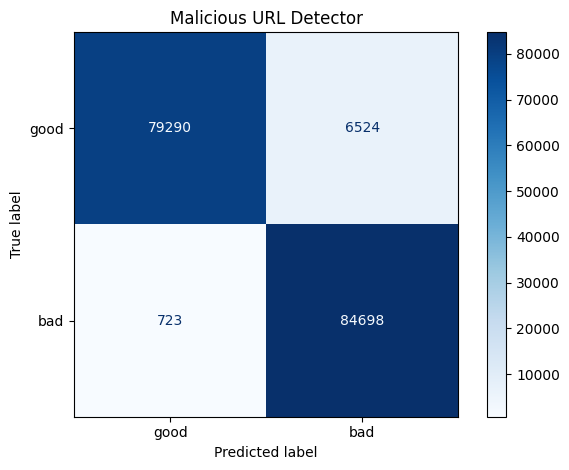

In [12]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Malicious URL Detector")
plt.tight_layout()
plt.show()